<a href="https://colab.research.google.com/github/Akeshh/ICS661-Assignment3-part2/blob/main/ICS661_A3_Part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install rouge

In [2]:
import json
import random
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from rouge import Rouge
from tqdm import tqdm

In [3]:
# Set a fixed random seed for reproducibility
random.seed(42)

# Load the data from the JSON file
with open('/content/drive/MyDrive/CS661-Assignment2/jokes.json', 'r') as data_file:
    data = json.load(data_file)

# Shuffle the data to ensure random distribution
random.shuffle(data)

# Calculate the split index
split_index = int(0.9 * len(data))

# Split the data into train and test sets
train_data = data[:split_index]
test_data = data[split_index:]

# Print examples to verify
print("Train data example:", train_data[:1])
print("Test data example:", test_data[:1])

# Save the train and test sets as separate JSON files
with open('/content/drive/MyDrive/CS661-Assignment2/train_jokes.json', 'w') as train_file:
    json.dump(train_data, train_file, ensure_ascii=False, indent=4)

with open('/content/drive/MyDrive/CS661-Assignment2/test_jokes.json', 'w') as test_file:
    json.dump(test_data, test_file, ensure_ascii=False, indent=4)

print(f"Train set size: {len(train_data)}")
print(f"Test set size: {len(test_data)}")

Train data example: [{'ID': '1520', 'Joke': "I just read this article about short term memory I don't remember what it was about"}]
Test data example: [{'ID': '1100', 'Joke': 'What do you call a woman with one leg? Eileen'}]
Train set size: 1459
Test set size: 163


In [4]:
# Function to preprocess and tokenize data
def preprocess_data(data):
    inputs = []
    labels = []

    # Load GPT-2 tokenizer
    tokenizer = GPT2Tokenizer.from_pretrained('openai-community/gpt2-medium')

    # Add a padding token for GPT-2
    tokenizer.pad_token = tokenizer.eos_token  # Use eos_token as pad_token

    # Process each joke in the dataset
    for item in data:
        joke = item['Joke']

        # Split the joke into words
        words = joke.split()

        # Skip jokes that have fewer than 3 words
        if len(words) < 3:
            continue

        # Get the first three words as input
        first_three_words = " ".join(words[:3])

        # Store the first three words as input and the entire joke as the label
        inputs.append(first_three_words)
        labels.append(joke)

    # Encode inputs and labels using GPT-2 tokenizer with padding and truncation
    input_ids = [tokenizer.encode(text, add_special_tokens=True, max_length=100, padding="max_length", truncation=True) for text in inputs]
    label_ids = [tokenizer.encode(text, add_special_tokens=True, max_length=100, padding="max_length", truncation=True) for text in labels]

    # Convert to tensors
    input_ids = torch.tensor(input_ids)
    label_ids = torch.tensor(label_ids)

    return input_ids, label_ids

# Function to create a DataLoader
def create_dataloader(input_ids, label_ids, batch_size=32):
    # Create a TensorDataset from inputs and labels
    dataset = TensorDataset(input_ids, label_ids)

    # Create a DataLoader for batch processing
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

# Assuming you have already loaded train_data and test_data from your json files
# Preprocess and tokenize train and test data
train_input_ids, train_label_ids = preprocess_data(train_data)
test_input_ids, test_label_ids = preprocess_data(test_data)

# Create DataLoaders for train and test sets
train_dataloader = create_dataloader(train_input_ids, train_label_ids, batch_size=32)
test_dataloader = create_dataloader(test_input_ids, test_label_ids, batch_size=32)

# Print the sizes of the datasets
print(f'Train set size: {len(train_dataloader.dataset)}')
print(f'Test set size: {len(test_dataloader.dataset)}')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Train set size: 1457
Test set size: 163


In [5]:
# Load pre-trained GPT-2 tokenizer from Hugging Face
tokenizer = GPT2Tokenizer.from_pretrained('openai-community/gpt2-medium')

# Add padding token to GPT-2 tokenizer
tokenizer.pad_token = tokenizer.eos_token  # Set pad_token to eos_token

# Load pre-trained GPT-2 model with language modeling head
model = GPT2LMHeadModel.from_pretrained('openai-community/gpt2-medium')

# Set the model to train on GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Print model structure
print(model)

model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=50257, bias=False)
)


In [6]:
# Train function
# Train function with tqdm progress bar
import torch
from tqdm import tqdm
import os

# Train function with checkpoint saving
def train_model(model, train_dataloader, tokenizer, optimizer, num_epochs, device, checkpoint_dir="checkpoints"):
    model.train()
    total_train_loss = []
    best_loss = float('inf')  # Initialize best loss with a very large value

    # Ensure the checkpoint directory exists
    os.makedirs(checkpoint_dir, exist_ok=True)

    for epoch in range(num_epochs):
        epoch_loss = 0
        # Add tqdm for progress bar
        with tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}") as tqdm_loader:
            for batch in tqdm_loader:
                inputs, labels = batch
                inputs, labels = inputs.to(device), labels.to(device)

                # Zero gradients
                optimizer.zero_grad()

                # Forward pass
                outputs = model(input_ids=inputs, labels=labels)
                loss = outputs.loss  # Use the computed loss from the model

                # Backward pass and optimization step
                loss.backward()
                optimizer.step()

                # Track loss
                epoch_loss += loss.item()
                tqdm_loader.set_postfix({'Loss': loss.item()})

        avg_train_loss = epoch_loss / len(train_dataloader)
        total_train_loss.append(avg_train_loss)
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}")

        # Save the model if it has the best loss so far
        if avg_train_loss < best_loss:
            best_loss = avg_train_loss
            checkpoint_path = os.path.join(checkpoint_dir, f'best_model.pth')
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Checkpoint saved with train loss: {best_loss:.4f}")

    return total_train_loss, checkpoint_path  # Return the path of the best checkpoint


# Test function with checkpoint loading and ROUGE evaluation
def test_model(model, test_dataloader, tokenizer, device, checkpoint_path):
    # Load the saved best model checkpoint
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.eval()
    print(f"Loaded model from checkpoint: {checkpoint_path}")

    rouge = Rouge()
    total_rouge_scores = {"rouge-1": 0, "rouge-2": 0, "rouge-l": 0}
    count = 0

    with torch.no_grad():
        # Add tqdm for progress bar
        with tqdm(test_dataloader, desc="Testing") as tqdm_loader:
            for batch in tqdm_loader:
                inputs, labels = batch
                inputs = inputs.to(device)

                # Generate text using the model
                generated = model.generate(input_ids=inputs, max_new_tokens=100)

                # Decode both predicted and reference texts
                generated_text = tokenizer.decode(generated[0], skip_special_tokens=True)
                reference_text = tokenizer.decode(labels[0], skip_special_tokens=True)

                # Calculate ROUGE scores
                rouge_scores = rouge.get_scores(generated_text, reference_text)[0]
                total_rouge_scores["rouge-1"] += rouge_scores["rouge-1"]["f"]
                total_rouge_scores["rouge-2"] += rouge_scores["rouge-2"]["f"]
                total_rouge_scores["rouge-l"] += rouge_scores["rouge-l"]["f"]
                count += 1
                tqdm_loader.set_postfix({
                    'ROUGE-1': total_rouge_scores["rouge-1"] / count,
                    'ROUGE-2': total_rouge_scores["rouge-2"] / count,
                    'ROUGE-L': total_rouge_scores["rouge-l"] / count
                })

    # Average ROUGE scores over all test samples
    avg_rouge_scores = {key: score / count for key, score in total_rouge_scores.items()}
    return avg_rouge_scores


# Plotting function
def plot_results(train_loss, rouge_scores):
    epochs = range(1, len(train_loss) + 1)

    # Plot training loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'bo-', label="Train Loss")
    plt.title("Train Loss Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Plot ROUGE scores
    plt.subplot(1, 2, 2)
    plt.bar(rouge_scores.keys(), rouge_scores.values())
    plt.title("Test ROUGE Scores")
    plt.ylabel("ROUGE F1 Score")

    plt.tight_layout()
    plt.show()


Epoch 1/20: 100%|██████████| 46/46 [00:48<00:00,  1.05s/it, Loss=2.84]


Epoch 1/20, Train Loss: 5.5911
Checkpoint saved with train loss: 5.5911


Epoch 2/20: 100%|██████████| 46/46 [00:48<00:00,  1.05s/it, Loss=1.79]


Epoch 2/20, Train Loss: 1.9880
Checkpoint saved with train loss: 1.9880


Epoch 3/20: 100%|██████████| 46/46 [00:48<00:00,  1.06s/it, Loss=1.65]


Epoch 3/20, Train Loss: 1.7462
Checkpoint saved with train loss: 1.7462


Epoch 4/20: 100%|██████████| 46/46 [00:48<00:00,  1.06s/it, Loss=1.59]


Epoch 4/20, Train Loss: 1.6652
Checkpoint saved with train loss: 1.6652


Epoch 5/20: 100%|██████████| 46/46 [00:48<00:00,  1.06s/it, Loss=1.37]


Epoch 5/20, Train Loss: 1.5973
Checkpoint saved with train loss: 1.5973


Epoch 6/20: 100%|██████████| 46/46 [00:48<00:00,  1.06s/it, Loss=1.49]


Epoch 6/20, Train Loss: 1.4898
Checkpoint saved with train loss: 1.4898


Epoch 7/20: 100%|██████████| 46/46 [00:48<00:00,  1.06s/it, Loss=1.32]


Epoch 7/20, Train Loss: 1.4695
Checkpoint saved with train loss: 1.4695


Epoch 8/20: 100%|██████████| 46/46 [00:48<00:00,  1.06s/it, Loss=1.64]


Epoch 8/20, Train Loss: 1.4554
Checkpoint saved with train loss: 1.4554


Epoch 9/20: 100%|██████████| 46/46 [00:48<00:00,  1.06s/it, Loss=1.41]


Epoch 9/20, Train Loss: 1.4594


Epoch 10/20: 100%|██████████| 46/46 [00:48<00:00,  1.06s/it, Loss=1.29]


Epoch 10/20, Train Loss: 1.4216
Checkpoint saved with train loss: 1.4216


Epoch 11/20: 100%|██████████| 46/46 [00:48<00:00,  1.06s/it, Loss=1.6]


Epoch 11/20, Train Loss: 1.4177
Checkpoint saved with train loss: 1.4177


Epoch 12/20: 100%|██████████| 46/46 [00:48<00:00,  1.06s/it, Loss=1.8]


Epoch 12/20, Train Loss: 1.4064
Checkpoint saved with train loss: 1.4064


Epoch 13/20: 100%|██████████| 46/46 [00:48<00:00,  1.06s/it, Loss=1.16]


Epoch 13/20, Train Loss: 1.4160


Epoch 14/20: 100%|██████████| 46/46 [00:48<00:00,  1.06s/it, Loss=1.25]


Epoch 14/20, Train Loss: 1.3897
Checkpoint saved with train loss: 1.3897


Epoch 15/20: 100%|██████████| 46/46 [00:48<00:00,  1.06s/it, Loss=1.22]


Epoch 15/20, Train Loss: 1.3811
Checkpoint saved with train loss: 1.3811


Epoch 16/20: 100%|██████████| 46/46 [00:48<00:00,  1.06s/it, Loss=1.38]


Epoch 16/20, Train Loss: 1.3658
Checkpoint saved with train loss: 1.3658


Epoch 17/20: 100%|██████████| 46/46 [00:48<00:00,  1.06s/it, Loss=1.44]


Epoch 17/20, Train Loss: 1.3549
Checkpoint saved with train loss: 1.3549


Epoch 18/20: 100%|██████████| 46/46 [00:48<00:00,  1.06s/it, Loss=1.44]


Epoch 18/20, Train Loss: 1.3520
Checkpoint saved with train loss: 1.3520


Epoch 19/20: 100%|██████████| 46/46 [00:48<00:00,  1.06s/it, Loss=1.15]


Epoch 19/20, Train Loss: 1.3476
Checkpoint saved with train loss: 1.3476


Epoch 20/20: 100%|██████████| 46/46 [00:48<00:00,  1.06s/it, Loss=1.42]


Epoch 20/20, Train Loss: 1.3268
Checkpoint saved with train loss: 1.3268


<ipython-input-6-a97dd60565fd>:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location=device))


Loaded model from checkpoint: checkpoints/best_model.pth


Testing:   0%|          | 0/6 [00:00<?, ?it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Testing:  17%|█▋        | 1/6 [00:00<00:02,  1.80it/s, ROUGE-1=0.261, ROUGE-2=0.182, ROUGE-L=0.261]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` 

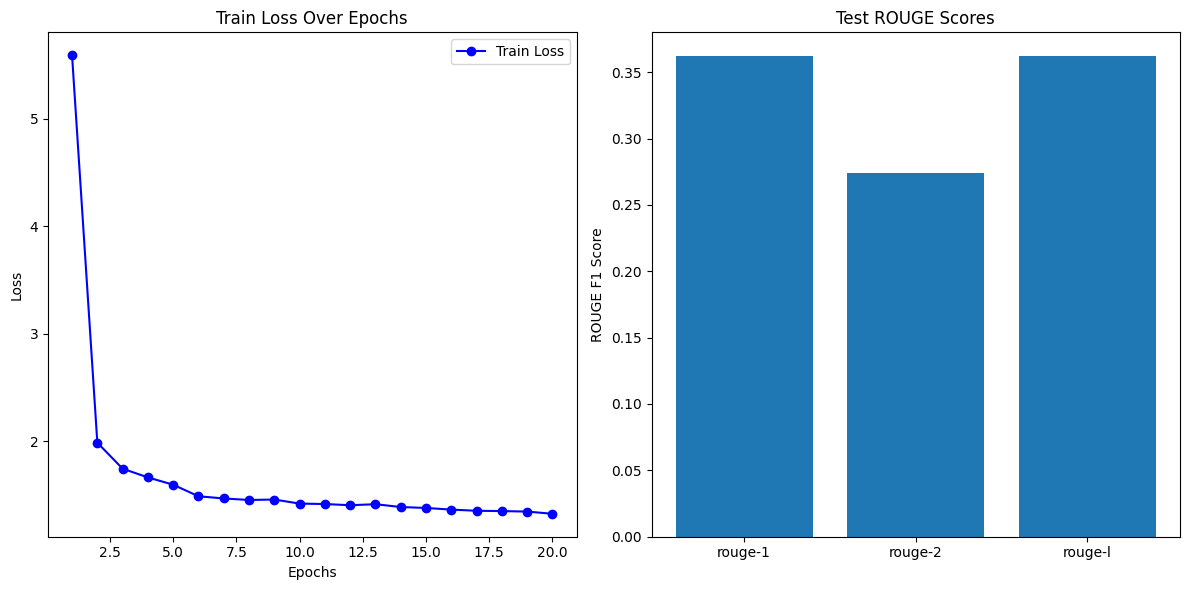

In [7]:
# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)


# Example of how to use the functions
train_loss, path = train_model(model, train_dataloader, tokenizer, optimizer, num_epochs=20, device=device)
rouge_scores = test_model(model, test_dataloader, tokenizer, device, path)

# Plot train loss and test ROUGE results
plot_results(train_loss, rouge_scores)

In [8]:
# use the same random seed
random_seed = 42
random.seed(random_seed)
torch.manual_seed(random_seed)


def generate_joke(model, tokenizer, input_text, max_length=50):
    inputs = tokenizer(input_text, return_tensors="pt").to(model.device)
    output = model.generate(inputs['input_ids'], max_length=max_length, num_return_sequences=1, no_repeat_ngram_size=2)
    return tokenizer.decode(output[0], skip_special_tokens=True)


tokenizer.pad_token = tokenizer.eos_token


def generate_joke(model, tokenizer, input_text, max_length=50):
    inputs = tokenizer(input_text, return_tensors="pt", padding=True).to(model.device)
    attention_mask = inputs['attention_mask']


    output = model.generate(inputs['input_ids'], attention_mask=attention_mask,
                            max_length=max_length, num_return_sequences=1, no_repeat_ngram_size=2,
                            pad_token_id=tokenizer.eos_token_id)
    return tokenizer.decode(output[0], skip_special_tokens=True)

# comparing with golden label
def generate_and_compare(test_data, model, tokenizer, num_examples=5):
    for i in range(num_examples):
        # 从test_data中读取一个样本（前3个词作为输入，句子作为golden label）
        example = test_data[i]
        full_joke = example['Joke']
        three_words_input = ' '.join(full_joke.split()[:3])
        golden_label = full_joke

        # 用前3个词生成的笑话
        generated_joke = generate_joke(model, tokenizer, three_words_input)

        # Comparison
        print(f"Example {i + 1}:")
        print(f"Three words input: {three_words_input}")
        print(f"Golden label: {golden_label}")
        print(f"Generated joke (using first 3 words): {generated_joke}")
        print()

# 随机选择三个词生成笑话
def generate_random_words_joke(test_data, model, tokenizer, num_examples=5):
    for i in range(num_examples):

        example = test_data[i]
        full_joke = example['Joke']
        words = full_joke.split()

        # 随机选择三个不连续的单词
        random.seed(random_seed)
        random_indices = sorted(random.sample(range(len(words)), 3))
        random_three_words = ' '.join([words[idx] for idx in random_indices])


        random_generated_joke = generate_joke(model, tokenizer, random_three_words)


        three_words_input = ' '.join(words[:3])
        generated_joke_from_three_words = generate_joke(model, tokenizer, three_words_input)

        # Comparison
        print(f"Example {i + 1}:")
        print(f"Random three words input: {random_three_words}")
        print(f"Generated joke (using random 3 words): {random_generated_joke}")
        print(f"Generated joke (using first 3 words): {generated_joke_from_three_words}")
        print(f"Golden label: {full_joke}")
        print()

# 5 examples
generate_and_compare(test_data, model, tokenizer, num_examples=5)

# 5 examples
generate_random_words_joke(test_data, model, tokenizer, num_examples=5)

Example 1:
Three words input: What do you
Golden label: What do you call a woman with one leg? Eileen
Generated joke (using first 3 words): What do you call call? call a?? A?

Example 2:
Three words input: What do you
Golden label: What do you call a dead fly? a flew
Generated joke (using first 3 words): What do you call call? call a?? A?

Example 3:
Three words input: Why should you
Golden label: Why should you always bring 2 pair of trousers when golfing? In case you get a hole in one.
Generated joke (using first 3 words): Why should you the the you you?? a? the?

Example 4:
Three words input: Why don't tennis
Golden label: Why don't tennis players get married? Because to them love means nothing.
Generated joke (using first 3 words): Why don't tennis the the say the?? the a?

Example 5:
Three words input: What's red and
Golden label: What's red and bad for your teeth? A brick.
Generated joke (using first 3 words): What's red and?? a? the? A?

Example 1:
Random three words input: What